# First we import our CIFAR-10 dataset

In [33]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

DATA_DIR = "data"
BATCH_SIZE = 64

train_dataset = CIFAR10(root=DATA_DIR, train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
test_dataset = CIFAR10(root=DATA_DIR, train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

num_train_images = len(train_dataset)
num_test_images = len(test_dataset)

image_shape = train_dataset[0][0].shape

print(f"Loaded batches of size {BATCH_SIZE}:")
print(f" - {len(train_dataloader)} batches for training ({num_train_images} images)")
print(f" - {len(test_dataloader)} batches for validation ({num_test_images} images)")
print(f"for a total of {num_train_images + num_test_images} images (Shape: {image_shape}).")

Loaded batches of size 64:
 - 781 batches for training (50000 images)
 - 157 batches for validation (10000 images)
for a total of 60000 images (Shape: torch.Size([3, 32, 32])).


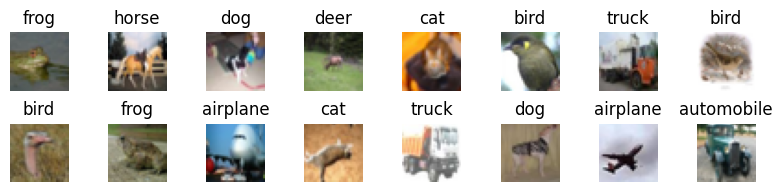

In [34]:
import matplotlib.pyplot as plt


def show_some_images(num_images, num_rows, dataloader, classes):
    num_cols = num_images // num_rows

    images, labels = next(iter(dataloader))
    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(classes[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_some_images(16, 2, train_dataloader, train_dataset.classes)

In [35]:
import torch
from unet import UNet
from vdm import VDM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Training Results Visualization

In [ ]:
# Training configuration
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

from tqdm import tqdm
import torch.optim as optim

unet = UNet()
vdm = VDM(unet, image_shape=image_shape, device=device)
vdm = vdm.to(device)

optimizer = optim.AdamW(vdm.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99), weight_decay=0.01, eps=1e-8)

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}, Batches per epoch: {len(train_dataloader)}")

# Training loop
training_losses = []
training_bpds = []

for epoch in range(NUM_EPOCHS):
    vdm.train()
    epoch_loss = 0.0
    epoch_bpd = 0.0

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)

        # Forward pass
        optimizer.zero_grad()
        loss, bpd, bpd_components = vdm(images)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vdm.parameters(), 1.0)
        optimizer.step()

        # Track metrics
        epoch_loss += loss.item()
        epoch_bpd += bpd.item()

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{loss.item():.4f}",
                "bpd": f"{bpd.item():.4f}",
                "recon": f'{bpd_components["bpd_recon"]:.3f}',
                "kl": f'{bpd_components["bpd_klz"]:.3f}',
                "diff": f'{bpd_components["bpd_diff"]:.3f}',
            }
        )

    # Calculate epoch averages
    avg_loss = epoch_loss / len(train_dataloader)
    avg_bpd = epoch_bpd / len(train_dataloader)
    training_losses.append(avg_loss)
    training_bpds.append(avg_bpd)

    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, BPD: {avg_bpd:.4f}")

print("\nTraining completed!")

# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, NUM_EPOCHS + 1), training_losses, marker="o", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, NUM_EPOCHS + 1), training_bpds, marker="o", linewidth=2, color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("BPD")
axes[1].set_title("Training BPD")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generate Samples from Model

In [ ]:
# Set model to evaluation mode
vdm.eval()

# Generate samples
print("Generating samples from the model...")
print("This may take a few minutes...")

num_samples = 16
n_sample_steps = 100  # Number of denoising steps

with torch.no_grad():
    samples = vdm.sample(batch_size=num_samples, n_sample_steps=n_sample_steps, clip_samples=True)
    samples = samples.cpu()

print(f"Generated {num_samples} samples with {n_sample_steps} denoising steps")

In [ ]:
# Visualize generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i in range(num_samples):
    img = samples[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    axes[i].imshow(img)
    axes[i].axis("off")

plt.suptitle("Generated Samples from VDM", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
# Show real images alongside generated ones
fig, axes = plt.subplots(2, 8, figsize=(12, 3.5))

# Real images (top row)
real_images, real_labels = next(iter(test_dataloader))
for i in range(8):
    img = real_images[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Real", loc="left", fontsize=10)

# Generated images (bottom row)
for i in range(8):
    img = samples[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("Generated", loc="left", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Generate samples and save intermediate steps to visualize denoising
vdm.eval()
num_steps = 100
steps_to_show = [0, 10, 25, 50, 75, 90, 99]

z = torch.randn((1, *image_shape), device=device)
steps = torch.linspace(1.0, 0.0, num_steps + 1, device=device)

intermediate_steps = []
with torch.no_grad():
    for i in range(num_steps):
        if i in steps_to_show:
            # Decode current z to image space
            g_t = vdm.gamma_schedule(steps[i])
            z_rescaled = z / torch.sqrt(torch.sigmoid(-g_t))
            intermediate_steps.append((i, z_rescaled.cpu().clone()))

        z = vdm.sample_p_s_t(z, steps[i], steps[i + 1], clip_samples=True)

    # Add final result
    g_0 = vdm.gamma_schedule(torch.tensor(0.0, device=device))
    z_0_rescaled = z / torch.sqrt(torch.sigmoid(-g_0))
    logprobs = vdm.decode(z_0_rescaled, g_0)
    final_img = torch.argmax(logprobs, dim=-1).float() / (vdm.vocab_size - 1)
    intermediate_steps.append((num_steps, final_img.cpu()))

# Visualize the denoising process
fig, axes = plt.subplots(1, len(intermediate_steps), figsize=(16, 2.5))

for idx, (step_num, img_tensor) in enumerate(intermediate_steps):
    img = img_tensor[0].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[idx].imshow(img)
    axes[idx].set_title(f"Step {step_num}", fontsize=9)
    axes[idx].axis("off")

plt.suptitle("Denoising Process: From Noise to Image", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()